In [1]:
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.mlab as mlab
from scipy.interpolate import interp1d
import h5py
import json
import os
from scipy import signal as sig
from scipy.interpolate import interp1d

# Specify location of data
folder = 'LOSC_Event_tutorial/'
plt.style.use('seaborn-muted')

In [2]:
def read_template(filename):
    dataFile=h5py.File(filename,'r')
    template=dataFile['template']
    th=template[0]
    tl=template[1]
    return th,tl

def read_file(filename):
    dataFile=h5py.File(filename,'r')
    dqInfo = dataFile['quality']['simple']
    qmask=dqInfo['DQmask'][...]

    meta=dataFile['meta']
    #gpsStart=meta['GPSstart'].value
    gpsStart=meta['GPSstart'][()]
    #print meta.keys()
    #utc=meta['UTCstart'].value
    utc=meta['UTCstart'][()]
    #duration=meta['Duration'].value
    duration=meta['Duration'][()]
    #strain=dataFile['strain']['Strain'].value
    strain=dataFile['strain']['Strain'][()]
    dt=(1.0*duration)/len(strain)

    dataFile.close()
    return strain,dt,utc

# Import Data

In [3]:
file_names = os.listdir(folder)

# Save events from Hanford, Livingston and corresponding GW template
L_events = []
H_events = []
for file in file_names: 
    if file[0] == 'H':
        H_events.append(file)
        for j in file_names: 
            if j[:] == 'L-L1_LOSC_4' + file[11:]:
                L_events.append(j)

# Save GW templates manually, making sure it corresponds to correct event
GW = ['GW170104_4_template.hdf5','GW151226_4_template.hdf5','LVT151012_4_template.hdf5','GW150914_4_template.hdf5']

In [4]:
print('''
Handford Events:
-----------------
{0}

Livinston Events:
-----------------
{1}

GW Templates:
-----------------
{2}
'''.format(H_events, L_events, GW))


Handford Events:
-----------------
['H-H1_LOSC_4_V1-1167559920-32.hdf5', 'H-H1_LOSC_4_V2-1135136334-32.hdf5', 'H-H1_LOSC_4_V2-1128678884-32.hdf5', 'H-H1_LOSC_4_V2-1126259446-32.hdf5']

Livinston Events:
-----------------
['L-L1_LOSC_4_V1-1167559920-32.hdf5', 'L-L1_LOSC_4_V2-1135136334-32.hdf5', 'L-L1_LOSC_4_V2-1128678884-32.hdf5', 'L-L1_LOSC_4_V2-1126259446-32.hdf5']

GW Templates:
-----------------
['GW170104_4_template.hdf5', 'GW151226_4_template.hdf5', 'LVT151012_4_template.hdf5', 'GW150914_4_template.hdf5']



# PART A: ESTIMATING NOISE MODEL

To estimate the noise model, I'm going to average the PSD over all the events to average out the signal (and since the system noise is time invariant). I'll also make sure to window the data using the Tukey model, which is flat in the center where the signal is most likely to be. 

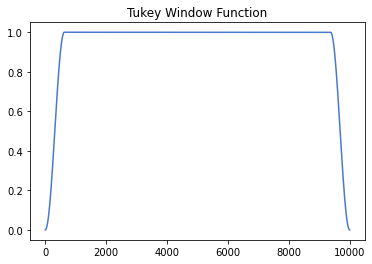

In [5]:
# To get an idea of the window function I am going to use, I've plotted an example below. 
tukey_window = sig.windows.tukey(10000, alpha=0.125)
plt.plot(tukey_window)
plt.title('Tukey Window Function')
plt.show()

In [6]:
def get_noise_model(events):
    
    PSD = 0
    for i in events:
        strain, dt, utc = read_file(folder + i)
        N = len(strain)
        
        # Window the function
        window = sig.windows.tukey(N, alpha = 0.2)
        
        # Get PSD
        psd = np.abs(np.fft.rfft(strain*window))**2
        PSD+=psd
    
    # Average
    noise_model = PSD/len(events)
    
    return noise_model

# Get the noise model for each of the detectors
raw_noise_model_H = get_noise_model(H_events)
raw_noise_model_L = get_noise_model(L_events)

In [7]:
# Smooth the noise models
def smooth_data(noise, n_smooth):
    smoothed = np.convolve(noise, np.ones(n_smooth)/n_smooth, mode = 'same')
    return smoothed

smooth_noise_H = smooth_data(raw_noise_model_H, 100)
smooth_noise_L = smooth_data(raw_noise_model_L, 100)

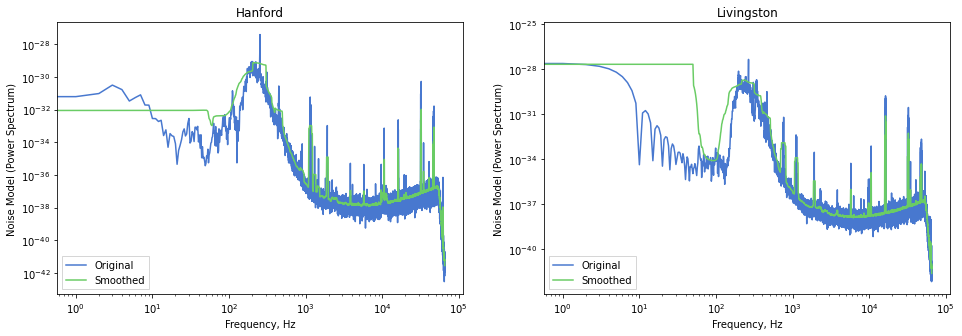

In [8]:
# Plot raw vs smoothed noise models

# Plot
fig, axs = plt.subplots(1,2, figsize = (16,5))
axs[0].loglog((raw_noise_model_H), label = 'Original')
axs[0].loglog(smooth_noise_H,label = 'Smoothed')
axs[0].set_title('Hanford')
leg0 = axs[0].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)

axs[1].loglog(raw_noise_model_L, label = 'Original')
axs[1].loglog(smooth_noise_L,label = 'Smoothed')
axs[1].set_title('Livingston')
leg1 = axs[1].legend(loc="lower left",
                 ncol=1, shadow=False, fancybox=False)


for ax in axs.flat:
    ax.set(xlabel = 'Frequency, Hz', ylabel='Noise Model (Power Spectrum)')

Some additional notes on the above:
- I've smoothed out the noise model: however, I have not removed the big spikes since they are intrinsic to the actual noise. I have, however, removed small scale oscilations that were most likely just white noise. 
- The data we care about lies in the range of ~20 Hz to ~2000 Hz (according to LIGO). Consequently, it doesn't matter that the noise model for frequencies lower than this don't follow the data that closely. 

# PART B: MATCHED FILTERS

### Whitening the data

Using the noise model, we can now whiten our data and look for the signal. 

In [9]:
def whiten(signal, noise_model, fs = 4096):
    
    spectr = np.fft.rfft(signal)
    
    white_ft = spectr / np.sqrt(noise_model) / fs
    
    return white_ft

def xcorr(strain, template, noise_model, fs = 4096):
    
    # Get window
    window = sig.windows.tukey(len(strain), alpha = 0.125)

    # Get whitened data in Fourier space, making sure to window the data and template
    strain_ft_whitened = whiten(strain*window, noise_model, fs = fs)
    template_ft_whitened = whiten(template*window, noise_model, fs = fs)
    
    # Get matched filter
    xcorr = np.fft.irfft(strain_ft_whitened*np.conj(template_ft_whitened))
    
    return xcorr

EVENT: 1
_____________


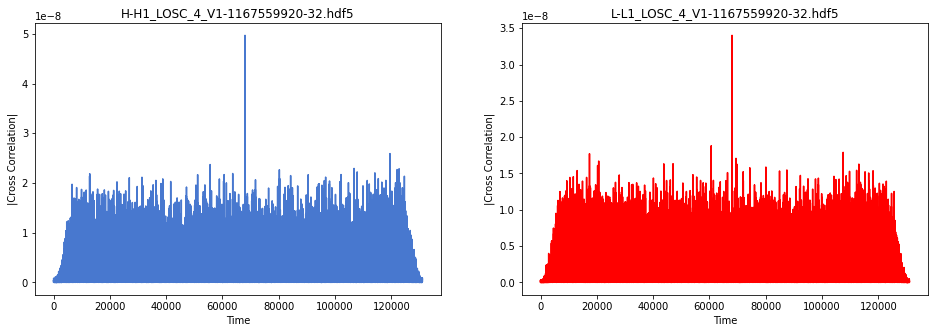

EVENT: 2
_____________


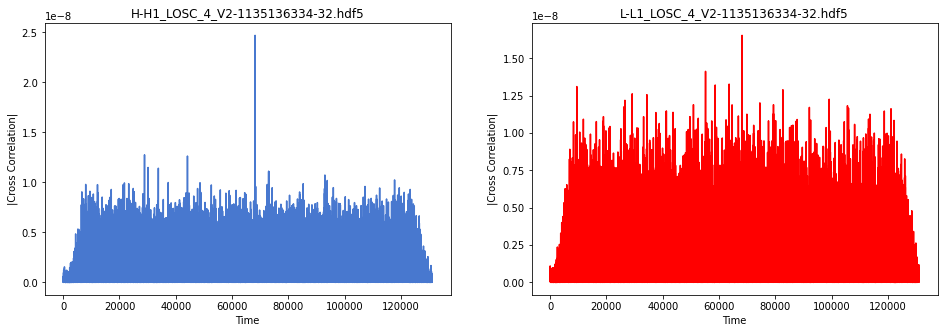

EVENT: 3
_____________


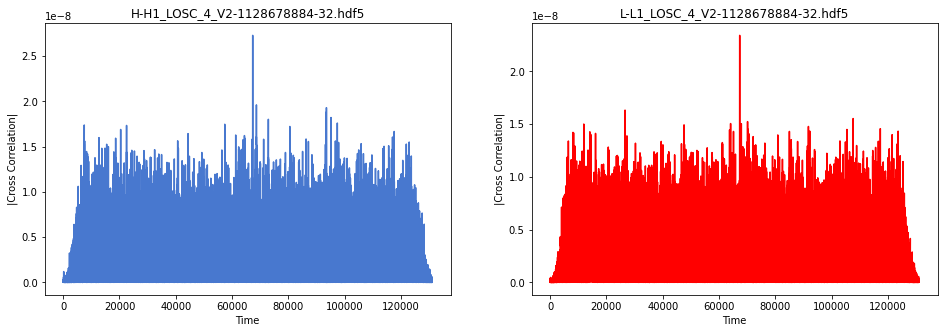

EVENT: 4
_____________


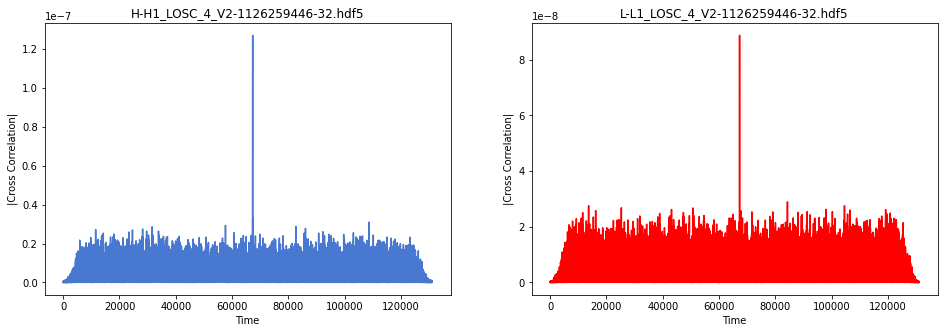

In [10]:
# Let's see how we did! 
xcorrs_H = np.empty([4,131072], dtype = 'complex')
xcorrs_L = np.empty([4,131072], dtype = 'complex')

for i in range(4):
    # Load in each event
    H_i, dt, utc = read_file(folder + H_events[i])
    L_i, dt, utc = read_file(folder + L_events[i])
    th_i, tl_i = read_template(folder + GW[i])
    
    # Get xcorr for each event
    xcorr_H_i = xcorr(H_i, th_i, smooth_noise_H)
    xcorr_L_i = xcorr(L_i, tl_i, smooth_noise_L)

    # Save data for analysis later
    xcorrs_H[i,:] = xcorr_H_i
    xcorrs_L[i,:] = xcorr_L_i
    
    N = len(xcorr_H_i)
    
    # Plot 
    print('EVENT: {0}'.format(i+1))
    print('_____________')
    fig, axs = plt.subplots(1,2, figsize = (16,5))
    axs[0].plot(np.abs(np.roll(xcorr_H_i, N//2)), label = H_events[i])
    axs[0].set_title(H_events[i])
    #leg0 = axs[0].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    axs[1].plot(np.abs(np.roll(xcorr_L_i, N//2)), label = L_events[i], color = 'red')
    axs[1].set_title(L_events[i])
    #leg1 = axs[1].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    for ax in axs.flat:
        ax.set(xlabel = 'Time', ylabel= '|Cross Correlation|')
    
    plt.show()


# PART C: SIGNAL TO NOISE

##### NOTE: SEE LEGENDS WITHIN GRAPHS FOR OBTAINED SNR AND NOISE VALUES

In this section, we estimate the signal-to-noise ratio of the detection. 

We can estimate the noise by evaluating the standard deviation of the signal in an area that isn't affected by the window nor where a strong detection is. In all of the plots, a reasonable spot where the noise looks random is around 20000 - 40000 on the 'time' axis. 

### Individual SNRs

EVENT: 1
_____________


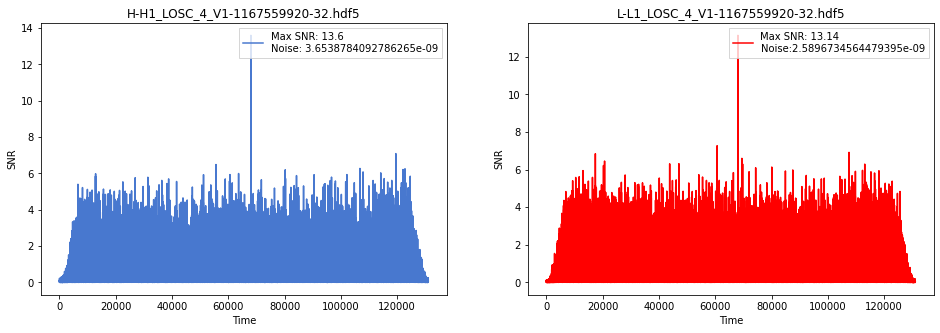

EVENT: 2
_____________


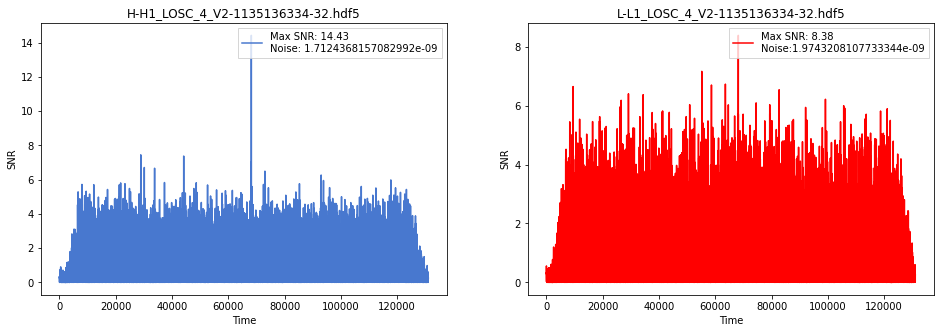

EVENT: 3
_____________


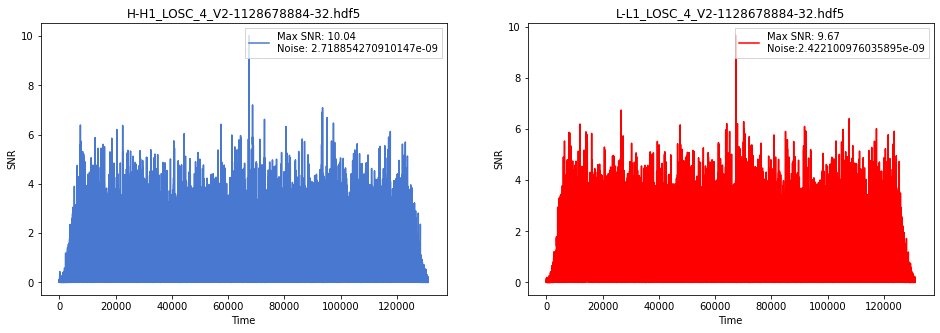

EVENT: 4
_____________


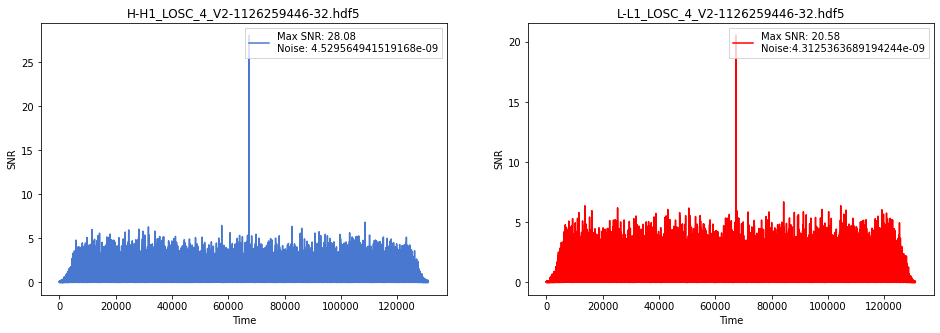

In [11]:
# Get noise of each event by estimating it from 20000-40000
N = xcorrs_H.shape[1]

# Roll to center 
rolled_H = np.roll(xcorrs_H, N//2, axis = 1)
abs_rolled_H = np.abs(rolled_H)

rolled_L = np.roll(xcorrs_L, N//2, axis = 1)
abs_rolled_L = np.abs(rolled_L)

# Get standard deviation of area that looks like random noise
noise_H_events = np.abs(np.std(abs_rolled_H[:,20000:40000], axis = 1))
noise_L_events = np.abs(np.std(abs_rolled_L[:,20000:40000], axis = 1))

indmax_SNR_H = []
indmax_SNR_L = []
max_SNR_H_list = []
max_SNR_L_list = []

for i in range(4):
    
    # Plot SNR Graphs 
    SNR_H_i = abs_rolled_H[i,:] / noise_H_events[i]
    SNR_L_i = abs_rolled_L[i,:] / noise_L_events[i]
    
    max_SNR_H = np.argmax(SNR_H_i)
    max_SNR_L = np.argmax(SNR_L_i)
    indmax_SNR_H.append(max_SNR_H)
    indmax_SNR_L.append(max_SNR_L)
    max_SNR_H_list.append(SNR_H_i[max_SNR_H])
    max_SNR_L_list.append(SNR_L_i[max_SNR_L])
    
    
    print('EVENT: {0}'.format(i+1))
    print('_____________')
    fig, axs = plt.subplots(1,2, figsize = (16,5))
    axs[0].plot(SNR_H_i, label = 'Max SNR: {0}\nNoise: {1}'.format(round(SNR_H_i[max_SNR_H], 2), noise_H_events[i]))
    axs[0].set_title(H_events[i])
    leg0 = axs[0].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    axs[1].plot(SNR_L_i, color = 'red', label = 'Max SNR: {0}\nNoise:{1}'.format(round(SNR_L_i[max_SNR_L], 2), noise_L_events[i]))
    axs[1].set_title(L_events[i])
    leg1 = axs[1].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    for ax in axs.flat:
        ax.set(xlabel = 'Time', ylabel= 'SNR')
    
    plt.show()

### Combined SNR

EVENT: 1
_____________


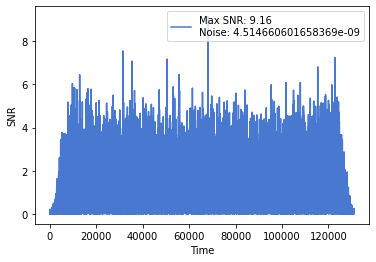

EVENT: 2
_____________


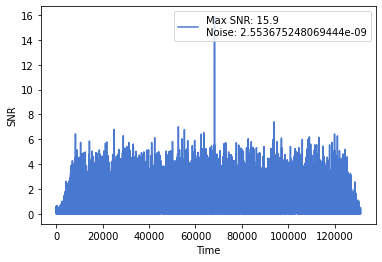

EVENT: 3
_____________


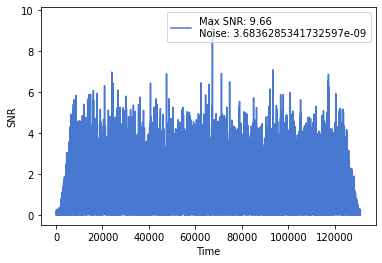

EVENT: 4
_____________


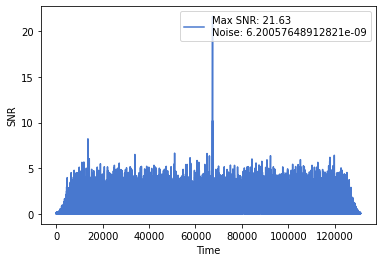

In [12]:
# Combine Cross Correlations
xcorr_combined = xcorrs_H + xcorrs_L
# Roll
rolled_comb = np.roll(xcorr_combined, N//2, axis = 1)
# Get absolute value
abs_rolled_comb = np.abs(rolled_comb)
# Get noise estimate
noise_combined = np.abs(np.std(abs_rolled_comb[:,20000:40000], axis = 1))

max_SNR_list = []
max_SNR_index = []
for i in range(4): 
    SNR_i = abs_rolled_comb[i,:] / noise_combined[i]
    max_SNR = np.argmax(SNR_i)
    max_SNR_index.append(max_SNR)
    max_SNR_list.append(SNR_i[max_SNR])
    
    print('EVENT: {0}'.format(i+1))
    print('_____________')
    fig = plt.figure(figsize = (6,4))
    plt.plot(SNR_i, label= 'Max SNR: {0}\nNoise: {1}'.format(round(SNR_i[max_SNR], 2), noise_combined[i]) )
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel('SNR')
    plt.show()

# PART D: COMPARING SNR TO THEORY

##### NOTE: SEE LEGENDS WITHIN GRAPHS FOR OBTAINED SNR AND NOISE VALUES

The theoretical noise is just the matched filter of the template with itself, as given in the tutorial. We then just sum over the cross correlation, take the absolute value and square root. 

EVENT: 1
_____________


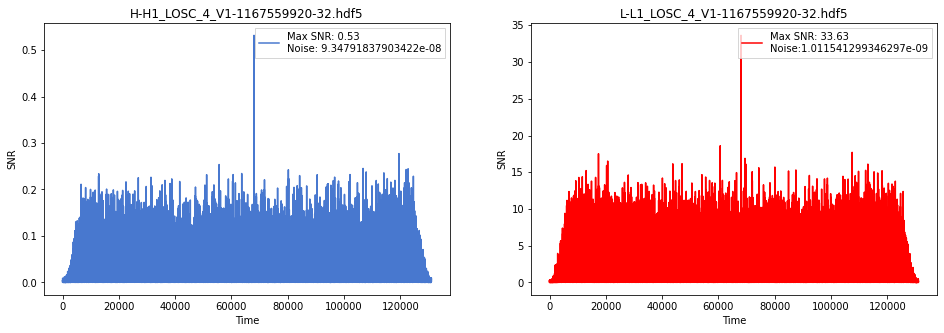

EVENT: 2
_____________


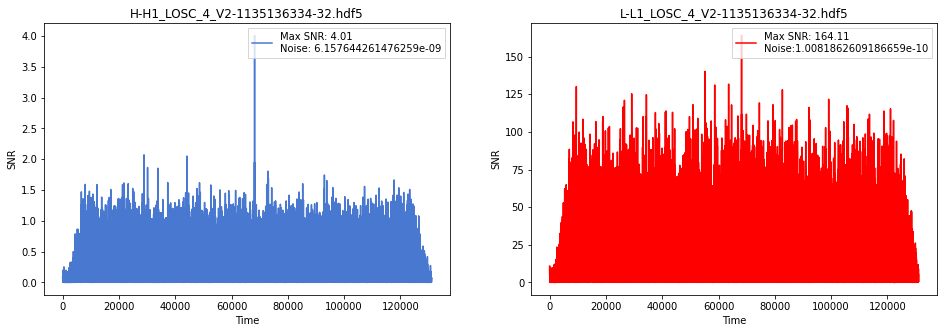

EVENT: 3
_____________


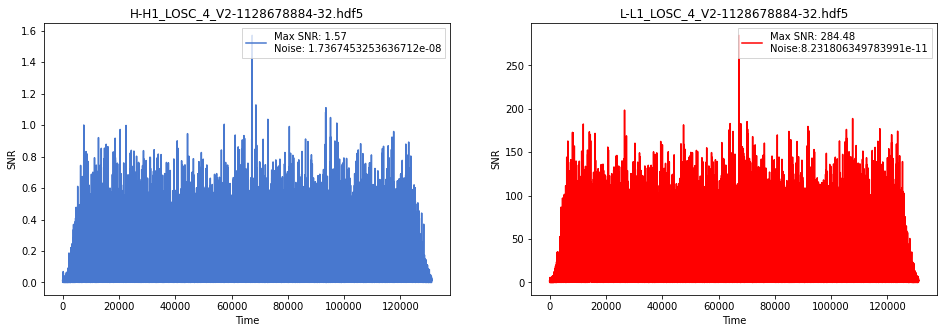

EVENT: 4
_____________


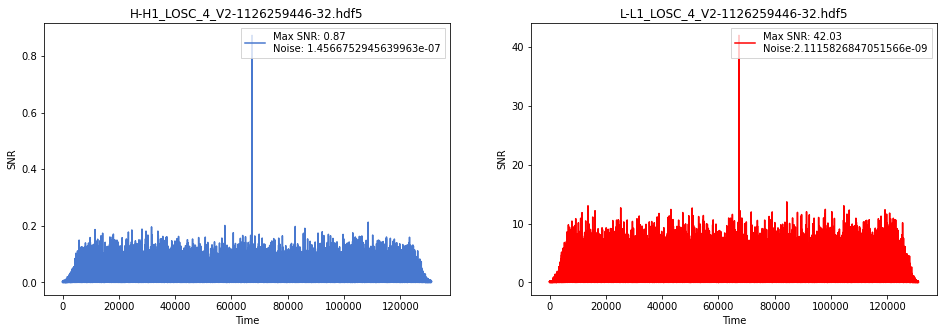

In [13]:
for i in range(4):
    
    th, tl = read_template(folder + GW[i])
    
    xcorr_th = xcorr(th, th, smooth_noise_H)
    xcorr_tl = xcorr(tl, tl, smooth_noise_L)
    
    # This is where we calculate the new noise
    sig_H = np.sqrt(np.abs(np.sum(xcorr_th)))
    sig_L = np.sqrt(np.abs(np.sum(xcorr_tl)))
    
    # Plot SNR Graphs 
    SNR_H_i = abs_rolled_H[i,:] / sig_H
    SNR_L_i = abs_rolled_L[i,:] / sig_L
    max_SNR_H = np.argmax(SNR_H_i)
    max_SNR_L = np.argmax(SNR_L_i)
    
    print('EVENT: {0}'.format(i+1))
    print('_____________')
    fig, axs = plt.subplots(1,2, figsize = (16,5))
    axs[0].plot(SNR_H_i, label = 'Max SNR: {0}\nNoise: {1}'.format(round(SNR_H_i[max_SNR_H], 2), sig_H))
    axs[0].set_title(H_events[i])
    leg0 = axs[0].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    axs[1].plot(SNR_L_i, color = 'red', label = 'Max SNR: {0}\nNoise:{1}'.format(round(SNR_L_i[max_SNR_L], 2), sig_L))
    axs[1].set_title(L_events[i])
    leg1 = axs[1].legend(loc = 'upper right', ncol=1, shadow=False, fancybox=False)
    
    for ax in axs.flat:
        ax.set(xlabel = 'Time', ylabel= 'SNR')
    
    plt.show()
    
   

Comparing the noise from the theoretical to the noise I obtained, we get a larger noise value for Hanford but smaller for Livingston. I cannot think of a reason as to why this is the case, but I imagine it has something to do with the templates and doing the cross correlation with itself. For some reason, I don't really trust this theoretical result that much given how different the answer is to what I got in PART C.

# PART E

The way I interpreted this question was that since it wanted a frequency, it made most sense to work in frequency space. Also, by whitening our data and looking at the power spectrum in fourier space, we can determine how much power is contained in the frequencies by summing up the power until we reach half of the total power. The results printed below highlight that most of the power is contained in the lower range of frequencies (which makes sense given the template).

In [14]:
half_freq_H = []
half_freq_L = []

for i in range(4): 
    
    # Load in template
    th, tl = read_template(folder + GW[i])
    freqs = np.fft.rfftfreq(len(th), 1/4096)
    
    
    #---------------------#
    #      Hanford        #
    #---------------------#
    h_fft_white = np.abs(whiten(th, smooth_noise_H)) 
    tot_h = np.sum(h_fft_white) # Get combined power
    sum_h = 0

    for j, freq in enumerate(freqs):
        
        sum_h+=h_fft_white[j]
        
        # Check if power exceeds 1/2 of total power. 
        if sum_h >= tot_h/2: 
            half_freq = freq
            break
            
    # Append corresponding frequency to list to save data.         
    half_freq_H.append(half_freq)
    
    #---------------------#
    #      Livingston     #
    #---------------------#
    
    # Repeat as above, but for Livingston template
    l_fft_white = np.abs(whiten(tl, smooth_noise_L))
    tot_l = np.sum(l_fft_white)
    sum_l = 0
    
    for j, freq in enumerate(freqs):
        
        sum_l+=l_fft_white[j]
        
        if sum_l >= tot_l/2:
            half_freq = freq
            break
    half_freq_L.append(half_freq)

    print('EVENT: {0}'.format(i+1))
    print('_____________')
    print("""
ν_H = {0} Hz              
ν_L = {1} Hz
    """.format(half_freq_H[i], half_freq_L[i]))
    print()

EVENT: 1
_____________

ν_H = 139.625 Hz              
ν_L = 138.375 Hz
    

EVENT: 2
_____________

ν_H = 151.21875 Hz              
ν_L = 167.9375 Hz
    

EVENT: 3
_____________

ν_H = 130.65625 Hz              
ν_L = 142.6875 Hz
    

EVENT: 4
_____________

ν_H = 135.3125 Hz              
ν_L = 145.90625 Hz
    



# PART F

To calculate the difference in arrival time, all we need to do is take the difference in the location of the indices where the SNR is maximum and multiply that by dt. 

In [15]:
# Recall that we saved the indices where the SNR is largest earlier, so we'll just call them now.
# time = (Δindex where SNR is max) * dt
dt = 1/4096
time = np.abs(np.asarray(indmax_SNR_H) - np.asarray(indmax_SNR_L)) * dt

for i in range(4):

    print('EVENT: {0}'.format(i+1))
    print('_____________')
    print("""
Δt_arrival = {0} s             
    """.format(time[i]))
    print()

EVENT: 1
_____________

Δt_arrival = 0.004638671875 s             
    

EVENT: 2
_____________

Δt_arrival = 0.00048828125 s             
    

EVENT: 3
_____________

Δt_arrival = 0.001953125 s             
    

EVENT: 4
_____________

Δt_arrival = 0.009033203125 s             
    



This question is extremely confusing and I wasn't sure how to interpret what it wanted, so I've given my interpretation below. Given that gravitational waves travel at the speed of light, the precision of the localization of the time arrival is highly dependent on the SNR of the detection, as we'd expect. For high SNR detection, we can expect roughly 1e2 km precision in positional uncertainty, whereas for low SNR bursts, we get roughly ~1e3 km uncertainty. This is highlighted in the plot I generated below where I compute the distance between the two detectors using d = c*\delta t, get the error by subtracting them from the true distance between the two dectors (3002 km), and plotting as a function of SNR.

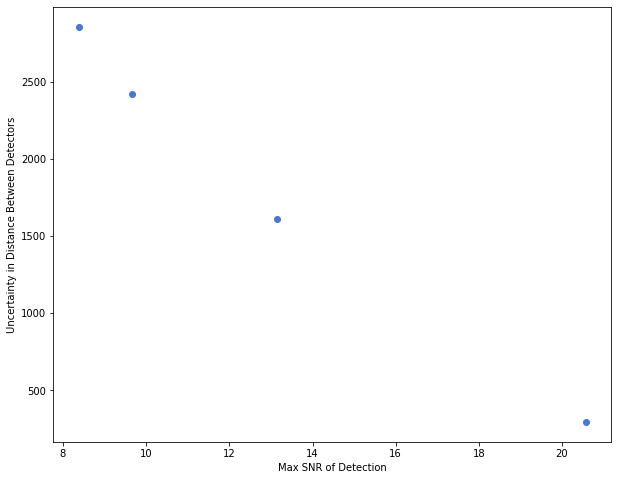

In [16]:
distances = 299792*np.asarray(time)
d_true = 3002 #km, from https://www.ligo.caltech.edu/page/facilities
error = np.abs(d_true - distances)
plt.figure(figsize = (10,8))
plt.scatter(max_SNR_L_list, error)
plt.xlabel('Max SNR of Detection')
plt.ylabel('Uncertainty in Distance Between Detectors')
plt.show()
